### In this notebook, I try to add stellar mass and redshift into $\vec{\theta}$, plus noise into the data and forward models

try to write this notebook in a more streamline way

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor
from torch.distributions import MultivariateNormal
from geomloss import SamplesLoss
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, StandardScaler

In [3]:
## Load the NN emulator `speculator`
with open('./speculator_best_recon_model_TZD.pkl', 'rb') as f:
    speculator = pickle.load(f)

speculator.params_name += ['logm', 'redshift']
speculator._build_params_prior()
speculator.bounds = np.array([speculator.prior[key] for key in speculator.params_name])
# speculator.network.eval();

noise = None # 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag.npy'

In [4]:
speculator.bounds

array([[ 0, 14],
       [-3,  3],
       [-3,  2],
       [ 0,  4],
       [ 0, 16],
       [ 0, 10]])

['tage', 'logtau', 'logzsol', 'dust2', 'log M*', 'redshift']

In [5]:
def gen_truth(sfh_kwargs, logz_logm_kwargs, 
              dust2_kwargs, redshift_kwargs, 
              nsamples=5000, random_state=None):
    if random_state is not None:
        torch.manual_seed(random_state)
    y_sfh = MultivariateNormal(torch.Tensor(sfh_kwargs['loc']), 
                               covariance_matrix=torch.Tensor(sfh_kwargs['cov'])
                              ).sample(sample_shape=(nsamples,))
    
    y_logz_logm = MultivariateNormal(torch.Tensor(logz_logm_kwargs['loc']), 
                                     torch.Tensor(logz_logm_kwargs['cov'])
                                    ).sample(sample_shape=(nsamples // 2,))
    y_logz_logm = torch.vstack([y_logz_logm, MultivariateNormal(torch.Tensor([-0.5, 8.5]), 
                             torch.Tensor(logz_logm_kwargs['cov']) * 0.5,
                            ).sample(sample_shape=(nsamples // 2,))])

    y_dust2 = torch.normal(mean=dust2_kwargs['mean'], std=dust2_kwargs['std'], size=(nsamples, 1))
    y_redshift = torch.normal(mean=redshift_kwargs['mean'], std=redshift_kwargs['std'], size=(nsamples, 1))
    
    Y_truth = torch.hstack([y_sfh, y_logz_logm[:, 0:1], y_dust2, y_logz_logm[:, 1:], y_redshift]).to('cuda')
    return Y_truth

In [6]:
sfh_kwargs = {'loc': [6, 0], 'cov': [[1, 0], [0, 0.3]]}
logz_logm_kwargs = {'loc': [-0.5, 10.5], 
                    'cov': [[0.3, 0.2], 
                            [0.4, 0.6]]}
dust2_kwargs = {'mean': 1, 'std': 0.5}
redshift_kwargs = {'mean': 0.15, 'std': 0.03}

In [7]:
Y_truth = gen_truth(sfh_kwargs, logz_logm_kwargs, 
                    dust2_kwargs, redshift_kwargs,
                    nsamples=5000, random_state=None)

In [8]:
# filters = ['hsc_{0}'.format(b) for b in 'grizy']
filters = ['galex_NUV'] + ['hsc_{0}'.format(b) for b in 'grizy'] + ['jwst_f090w', 'jwst_f115w', 'jwst_f140m']

In [9]:
filters

['galex_NUV',
 'hsc_g',
 'hsc_r',
 'hsc_i',
 'hsc_z',
 'hsc_y',
 'jwst_f090w',
 'jwst_f115w',
 'jwst_f140m']

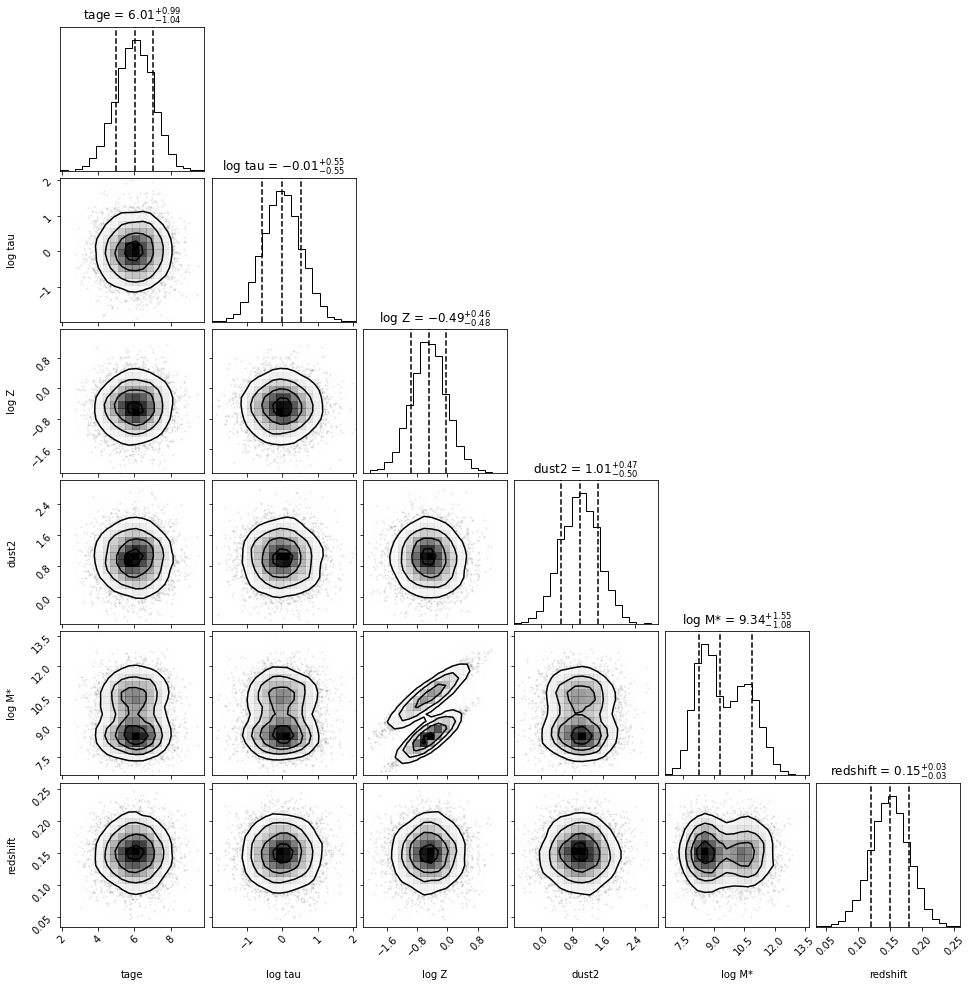

In [10]:
X_data = speculator._predict_mag_with_mass_redshift(
    Y_truth,
    filterset=filters,
    noise=noise, 
    noise_model_dir=noise_model_dir)
flag = ~(torch.isnan(X_data).any(dim=1) | torch.isinf(X_data).any(dim=1))

X_data = X_data[flag].detach()
Y_truth = Y_truth[flag]

# _X_data_clean = speculator.predict_mag(y_data, 
#                                 log_stellar_mass=y_stellar_mass, 
#                                 redshift=y_redshift,
#                                 filterset=['sdss_{0}0'.format(b) for b in 'ugriz'],
#                                 noise=None,
#                                ).cpu().detach().numpy()
# _X_data_clean = Tensor(_X_data_clean).to('cuda')
# _X_data_clean = _X_data_clean[~torch.isnan(_X_data_clean).any(dim=1)]

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       quantiles=[0.16, 0.5, 0.84], 
                       labels=['tage', 'log tau', 'log Z', 'dust2', 'log M*', 'redshift'],
                       smooth=0.7,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

In [11]:
X_train, X_vali, Y_train, Y_vali = train_test_split(X_data, Y_truth, test_size=0.2)

### We try to achieve our goal with loss = Sinkhorn(X, Y), where X is the observed SED, and Y is the model output.

In [16]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss
#del NDE_theta, samples

NDE_theta = WassersteinNeuralDensityEstimator(method='nsf', num_transforms=5, # 10, 
                                              num_bins=20, 
                                              hidden_features=50, # 120, 
                                              output_dir=None, 
#                                               initial_pos={'mean': [6, 3, 10.0, 0.05], 'std': [1, 1, 1, 0.05]},
                                              initial_pos={'mean': [7, 0, -0.5, 1.5, 10, 0.2], 
                                                           'std':  [1, 0.5, 0.3, 0.3, 1, 0.03], 
                                                           'perturb': [0.3, 0.3, 0.3, 0.3, 0.4, 0.01]
                                                          },
#                                               initial_pos={'mean': [5, 0, -0.5, 1.5, 10, 0.15], 
#                                                            'std':  np.array([1, 1, 0.1, 0.3, 1, 0.02]) / 5},
                                              normalize=False)
NDE_theta.build(
    Y_train,
    X_train,
    filterset=filters,
    optimizer='adam')

NDE_theta.load_validation_data(X_vali, Y_vali)

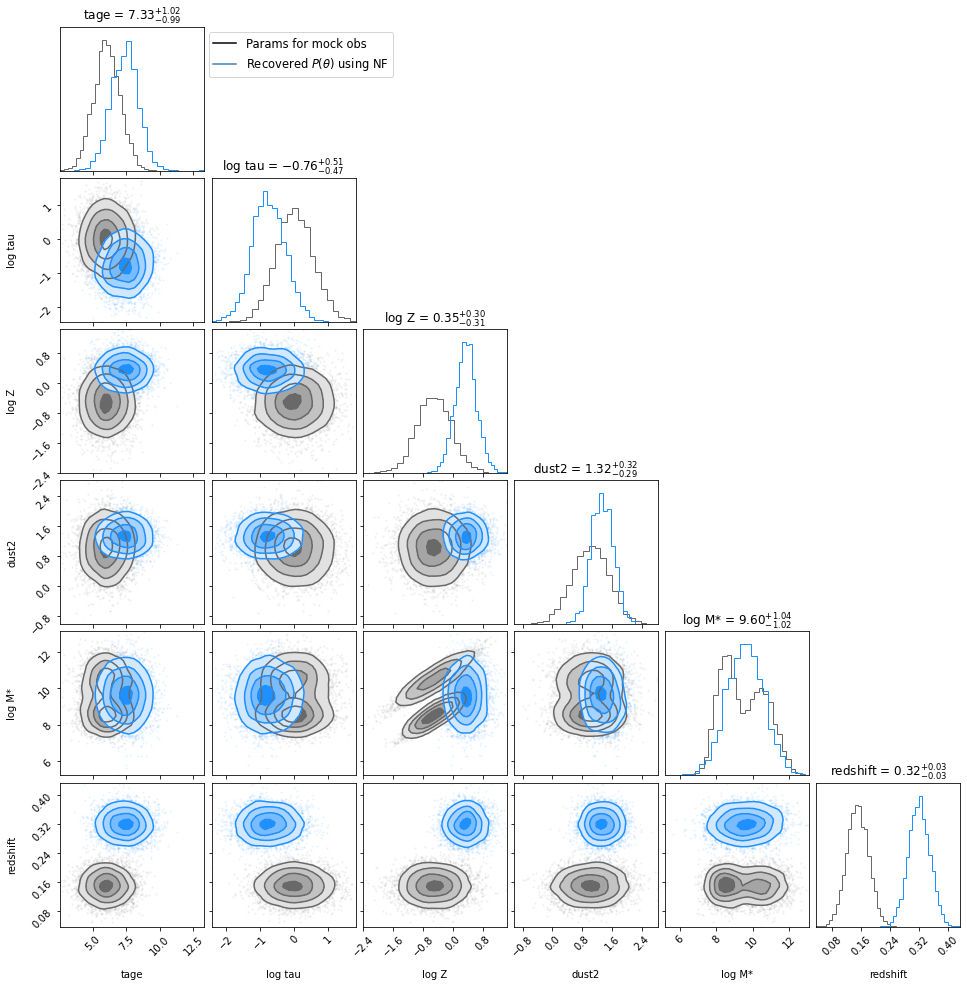

In [17]:
samples = NDE_theta.sample(5000)
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Recovered $P(\theta)$ using NF')

labels = ['tage', 'log tau', 'log Z', 'dust2', 'log M*', 'redshift']

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=25,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=1, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [12]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss
for i in range(8):
    NDE_theta = WassersteinNeuralDensityEstimator(method='nsf', 
                                                  name='TZD',
                                                  num_transforms=5, # 10, 
                                                  num_bins=20, 
                                                  hidden_features=50, # 120, 
                                                  output_dir='./nde_theta_TZD_multiband2/', 
                                                  initial_pos={'mean': [5, 0, -0.5, 1.5, 10, 0.2], 
                                                           'std':  [1, 0.5, 0.3, 0.3, 1, 0.03], 
                                                           'perturb': [0.3, 0.3, 0.3, 0.3, 0.4, 0.01]
                                                          },
                                                  normalize=False)
    NDE_theta.build(
        Y_train,
        X_train,
        filterset=filters,
        optimizer='adam')

    NDE_theta.load_validation_data(X_vali, Y_vali)

    max_epochs = 3
    scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                    max_lr=1e-3, 
                                                    steps_per_epoch=100, 
                                                    epochs=max_epochs)
    try:
        for epoch in range(max_epochs):
            print('lr:', NDE_theta.optimizer.param_groups[0]['lr'])
            NDE_theta.train(n_epochs=100, n_samples=5000,
                            speculator=speculator, 
                            noise=noise, noise_model_dir=noise_model_dir,
                            sinkhorn_kwargs={'p': 1, 'blur': 0.05, 'scaling': 0.5},
                            scheduler=scheduler
                           )
    except Exception as e:
        print(e)

lr: 3.9999999999999996e-05


Loss = 0.081 (train), 0.157 (vali), 0.000 (bad ratio):  91%|█████████████████████████████████▋   | 91/100 [00:43<00:04,  2.10epochs/s]


min(): Expected reduction dim 0 to have non-zero size.
lr: 3.9999999999999996e-05


Loss = 0.095 (train), 0.157 (vali), 0.002 (bad ratio): 100%|████████████████████████████████████| 100/100 [00:45<00:00,  2.18epochs/s]


lr: 0.0009932453239805729


Loss = 0.054 (train), 0.122 (vali), 0.000 (bad ratio): 100%|████████████████████████████████████| 100/100 [00:57<00:00,  1.73epochs/s]


lr: 0.0004551825248269011


Loss = 0.051 (train), 0.154 (vali), 0.001 (bad ratio): 100%|████████████████████████████████████| 100/100 [00:54<00:00,  1.84epochs/s]


lr: 3.9999999999999996e-05


Loss = 0.051 (train), 0.124 (vali), 0.000 (bad ratio): 100%|████████████████████████████████████| 100/100 [00:55<00:00,  1.79epochs/s]


lr: 0.0009932453239805729


Loss = 0.045 (train), 0.122 (vali), 0.000 (bad ratio): 100%|████████████████████████████████████| 100/100 [00:57<00:00,  1.73epochs/s]


lr: 0.0004551825248269011


Loss = 0.043 (train), 0.115 (vali), 0.000 (bad ratio): 100%|████████████████████████████████████| 100/100 [00:48<00:00,  2.06epochs/s]


lr: 3.9999999999999996e-05


Loss = 0.050 (train), 0.123 (vali), 0.000 (bad ratio): 100%|████████████████████████████████████| 100/100 [00:56<00:00,  1.78epochs/s]


lr: 0.0009932453239805729


Loss = 0.045 (train), 0.120 (vali), 0.000 (bad ratio): 100%|████████████████████████████████████| 100/100 [00:55<00:00,  1.81epochs/s]


lr: 0.0004551825248269011


Loss = 0.044 (train), 0.114 (vali), 0.000 (bad ratio): 100%|████████████████████████████████████| 100/100 [00:46<00:00,  2.13epochs/s]


lr: 3.9999999999999996e-05


Loss = 0.054 (train), 0.120 (vali), 0.000 (bad ratio): 100%|████████████████████████████████████| 100/100 [00:52<00:00,  1.89epochs/s]


lr: 0.0009932453239805729


Loss = 0.044 (train), 0.123 (vali), 0.000 (bad ratio): 100%|████████████████████████████████████| 100/100 [00:58<00:00,  1.70epochs/s]


lr: 0.0004551825248269011


Loss = 0.044 (train), 0.113 (vali), 0.000 (bad ratio): 100%|████████████████████████████████████| 100/100 [00:51<00:00,  1.94epochs/s]


lr: 3.9999999999999996e-05


Loss = 0.072 (train), 0.145 (vali), 0.000 (bad ratio): 100%|████████████████████████████████████| 100/100 [00:46<00:00,  2.14epochs/s]


lr: 0.0009932453239805729


Loss = 0.054 (train), 0.120 (vali), 0.000 (bad ratio): 100%|████████████████████████████████████| 100/100 [01:10<00:00,  1.41epochs/s]


lr: 0.0004551825248269011


Loss = 0.047 (train), 0.115 (vali), 0.000 (bad ratio): 100%|████████████████████████████████████| 100/100 [00:52<00:00,  1.91epochs/s]


lr: 3.9999999999999996e-05


Loss = 0.060 (train), 0.126 (vali), 0.000 (bad ratio): 100%|████████████████████████████████████| 100/100 [00:49<00:00,  2.01epochs/s]


lr: 0.0009932453239805729


Loss = 0.046 (train), 0.132 (vali), 0.000 (bad ratio): 100%|████████████████████████████████████| 100/100 [01:00<00:00,  1.65epochs/s]


lr: 0.0004551825248269011


Loss = 0.044 (train), 0.119 (vali), 0.000 (bad ratio): 100%|████████████████████████████████████| 100/100 [00:51<00:00,  1.94epochs/s]


lr: 3.9999999999999996e-05


Loss = 0.421 (train), 0.523 (vali), 0.000 (bad ratio):  13%|████▊                                | 13/100 [00:06<00:42,  2.06epochs/s]

min(): Expected reduction dim 0 to have non-zero size.


In [96]:
max_epochs = 3
scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=1e-3, 
                                                steps_per_epoch=100, 
                                                epochs=max_epochs)
for epoch in range(max_epochs):
    print('lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    NDE_theta.train(n_epochs=100, n_samples=3000,
                    speculator=speculator, 
                    noise=noise, noise_model_dir=noise_model_dir,
                    sinkhorn_kwargs={'p': 1, 'blur': 0.1, 'scaling': 0.8},
                    scheduler=scheduler
                   )
    #scheduler.step()

lr: 3.9999999999999996e-05


Loss = 0.058 (train), 0.123 (vali), 0.000 (bad ratio): 100%|████████████████████████████████████| 100/100 [00:45<00:00,  2.21epochs/s]


lr: 0.0009932453239805729


Loss = 0.034 (train), 0.082 (vali), 0.000 (bad ratio): 100%|████████████████████████████████████| 100/100 [00:48<00:00,  2.04epochs/s]


lr: 0.0004551825248269011


Loss = 0.031 (train), 0.099 (vali), 0.000 (bad ratio): 100%|████████████████████████████████████| 100/100 [00:46<00:00,  2.15epochs/s]


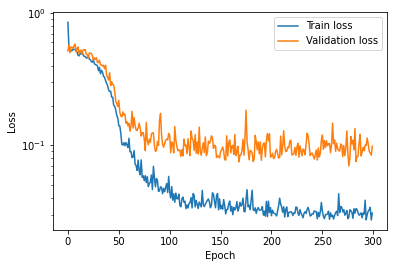

In [97]:
NDE_theta.plot_loss()
plt.yscale('log')

In [99]:
Y = NDE_theta.scaler.transform(
    speculator._predict_mag_with_mass_redshift(
        NDE_theta.sample(2000), filterset=filters)
)
# bad_ratio = (torch.isnan(Y).any(dim=1).sum() +
#              torch.isinf(Y).any(dim=1).sum()) / len(Y)
# val = 20.0
# Y = torch.nan_to_num(Y, val, posinf=val, neginf=-val)
# Y = Y[~(torch.isinf(Y).any(dim=1) | torch.isnan(Y).any(dim=1))]
# Y = torch.nan_to_num(Y, 0.0, posinf=0.0, neginf=-.0)

In [100]:
torch.isnan(Y).any(dim=1).sum()

tensor(0, device='cuda:0')

In [101]:
NDE_theta.sample(2000)

tensor([[ 6.1493, -0.0291, -0.0221,  0.7650, 10.5718,  0.1661],
        [ 6.5090, -0.2148, -0.4177,  0.8700,  8.2336,  0.1542],
        [ 6.9845, -0.4148, -0.5469,  1.0435,  8.8576,  0.1822],
        ...,
        [ 6.2088,  0.1932, -0.6056,  0.6961,  8.8786,  0.1543],
        [ 8.5601, -0.3471, -0.2928,  1.1006,  9.0704,  0.1620],
        [ 5.5831,  0.4598, -0.2620,  1.1422,  9.6792,  0.1471]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [102]:
NDE_theta.train_loss_history[np.argmin(NDE_theta.vali_loss_history)]

0.028665466234087944

In [103]:
print('Best epoch:', NDE_theta.best_loss_epoch)
print('Best train loss:', NDE_theta.train_loss_history[NDE_theta.best_loss_epoch - 1])
print('Best vali loss:', NDE_theta.vali_loss_history[NDE_theta.best_loss_epoch - 1])

Best epoch: 299
Best train loss: 0.027344508096575737
Best vali loss: 0.08433619141578674


In [104]:
NDE_theta.best_model.goodness_of_fit(Y_truth, p=1)

Log10 Wasserstein distance in theta space:  0.04065460003242771


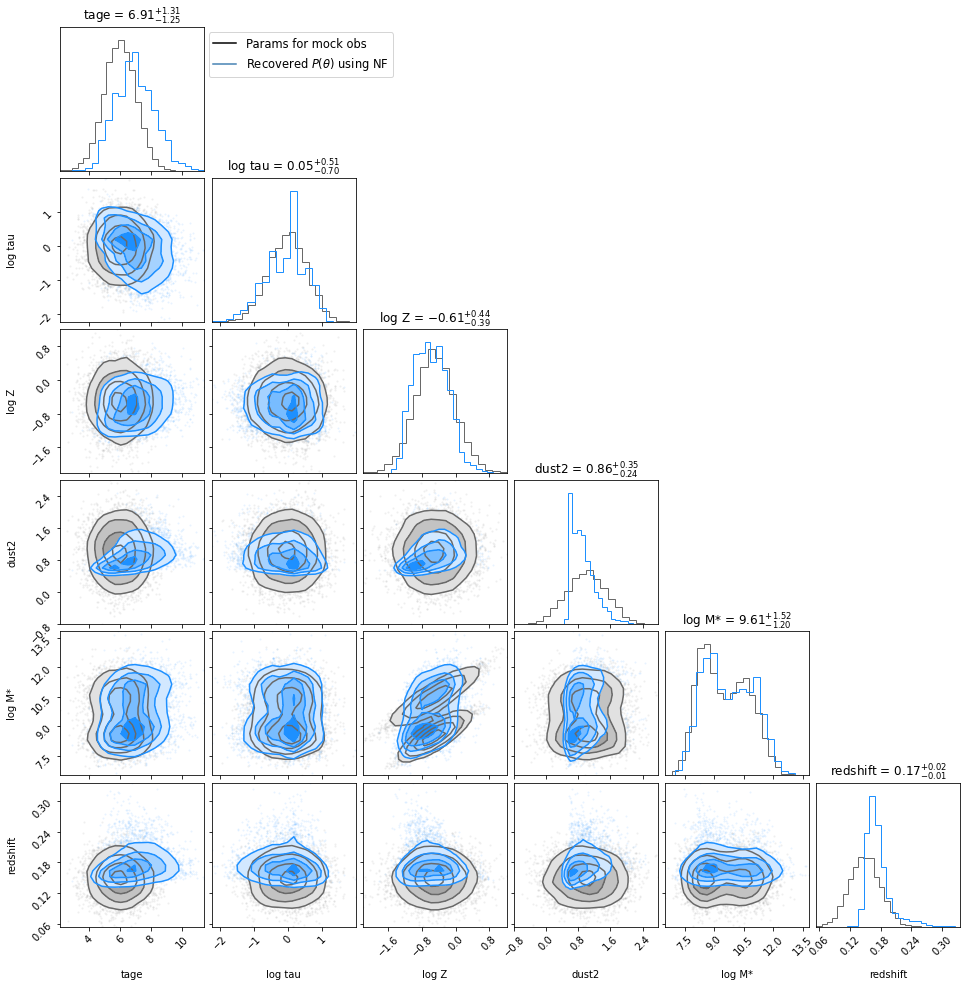

In [105]:
samples = NDE_theta.best_model.sample(5000)
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Recovered $P(\theta)$ using NF')

labels = ['tage', 'log tau', 'log Z', 'dust2', 'log M*', 'redshift']

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=20,
                       #range=[[2.0, 10.0], [-3, 4], [-2, 1], [0, 4], [8, 12], [-0.05, 0.2]],
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.8, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

samples = torch.nan_to_num(samples, 0, posinf=0, neginf=0)
nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=20,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.8, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('With noise')

0 5000


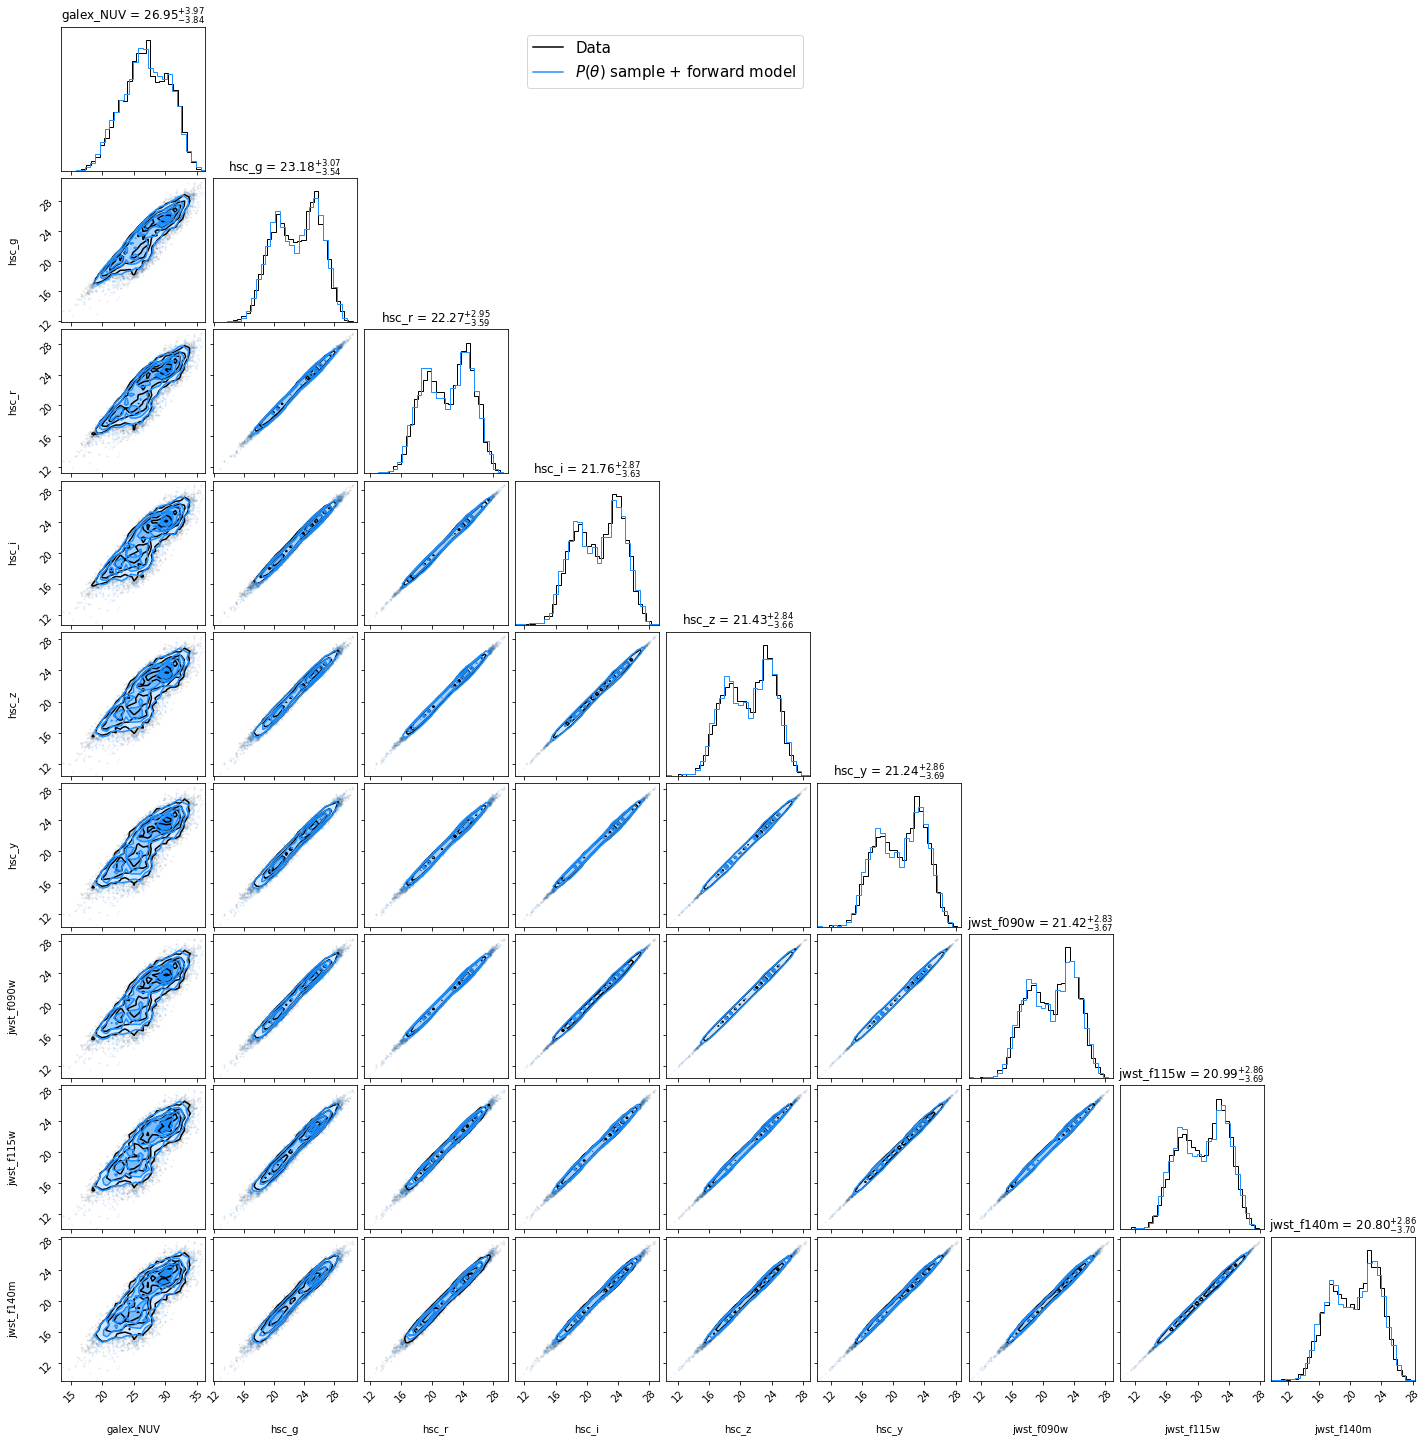

In [108]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = filters

figure = corner.corner(X_data.cpu().detach().numpy(), 
                       color='k', labels=labels, bins=30,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.4, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(samples,
                                                  filterset=filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [209]:
powers = torch.Tensor([200, 200, 200, 200, 200, 1000])
log_prior(NDE_theta.sample(3000),
                    torch.Tensor(speculator.bounds), powers).sum()

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

In [15]:
from geomloss import SamplesLoss

In [48]:
Y = speculator._predict_mag_with_mass_redshift(samples,
                                               noise=noise,
                                               noise_model_dir=noise_model_dir,
                                                  )
bad_mask = (torch.isnan(Y).any(dim=1) | torch.isinf(Y).any(dim=1))
bad_ratio = bad_mask.sum() / len(Y)
Y = Y[~bad_mask]

In [47]:
Y = NDE_theta.scaler.transform(
    speculator._predict_mag_with_mass_redshift(
        NDE_theta.sample(3996))
)
bad_mask = (torch.isnan(Y).any(dim=1) | torch.isinf(Y).any(dim=1))
bad_ratio = bad_mask.sum() / len(Y)
Y = Y[~bad_mask]

In [21]:
with open('./umap_mags.pkl', 'rb') as f:
    reducer = pickle.load(f)

In [68]:
embedding_Y = reducer.transform(Y.cpu().detach().numpy())
embedding_X = reducer.transform(X_train.cpu().detach().numpy())

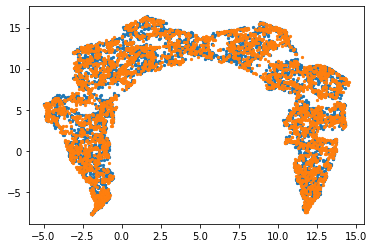

In [70]:
plt.scatter(embedding_Y[:, 0], embedding_Y[:, 1], s=5)
plt.scatter(embedding_X[:, 0], embedding_X[:, 1], s=5)

In [45]:
L = SamplesLoss(loss="sinkhorn", p=1, scaling=0.5, blur=0.01)

In [49]:
L(X_train, Y)

tensor(0.2975, device='cuda:0', grad_fn=<SelectBackward0>)

In [72]:
L(torch.Tensor(embedding_X), 
  torch.Tensor(embedding_Y))

tensor(0.1284)

In [158]:
torch.log10(L(NDE_theta.X, Y))

tensor(-1.5337, device='cuda:0', grad_fn=<SubBackward0>)

### Fuzzy logic?
$y = \log\left(\frac{1}{1 + |x / a|^{2b}}\right)$

In [424]:
bounds = np.array([[0, 14], [-3, 3], [-3, 2], [0, 4], [0, 16], [0, 10]])
powers = np.array([200, 200, 200, 200, 200, 1000])

In [379]:
def fuzzy_logic_prior(x, loc, width, power):
    return -100 * np.log10(1 / (1 + np.abs((x - loc) / width)**(power)))

def log_prior(theta, bounds, powers):
    width = (bounds[:, 1] - bounds[:, 0]) / 2
    loc = (bounds[:, 1] + bounds[:, 0]) / 2

    return np.sum([fuzzy_logic_prior(theta[i], loc[i], 10 ** (3
                  / powers[i]) * width[i], powers[i]) for i in
                  range(len(bounds))])

In [425]:
def fuzzy_logic_prior(x, loc, width, power):
    return -100 * torch.log10(1 / (1 + torch.abs((x - loc) / width)**(power)))

def log_prior(theta, bounds, powers):
    width = (bounds[:, 1] - bounds[:, 0]) / 2
    loc = (bounds[:, 1] + bounds[:, 0]) / 2

    return torch.vstack([fuzzy_logic_prior(spl[:, i], loc[i], 10 ** (3
              / powers[i]) * width[i], powers[i]) for i in
              range(len(bounds))]).sum(dim=0)

In [426]:
bounds = torch.Tensor([[0, 14], [-3, 3], [-3, 2], [0, 4], [0, 16], [0, 10]])
powers = torch.Tensor([200, 200, 200, 200, 200, 1000])

In [427]:
spl = NDE_theta.sample(100)

In [449]:
log_prior(spl, bounds, powers).sum()

tensor(365.4196, device='cuda:0', grad_fn=<SumBackward0>)

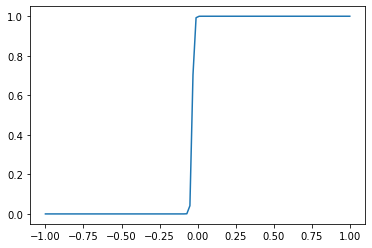

In [331]:
# bound = [0, 10]
# width = (bound[1] - bound[0]) / 2
# loc = (bound[1] + bound[0]) / 2

x = np.linspace(-1, 1, 100)
power = 1000
plt.plot(x, fuzzy_logic_prior(x, loc[-1], 10**(3 / power) * width[-1], power=power))

# plt.xlim(-0.1, 0.1)
# plt.ylim(0, 10)
#plt.axvline(0, c='k')